# Предсказание траекторий пешеходов

## Данные  (https://viratdata.org/ )

## Краткое описание: 
* 11 сцен со стационарных HD камер (1080p или 720p)
* 12 категорий аннотированных активностей [(описание доступно в полной документации к датасету)](https://data.kitware.com/api/v1/file/56f581c88d777f753209c9ce/download)
* Координаты коробок и описание для всех людей в сцене, а также объектов, с которыми они взаимодействуют

## Официальное описание данных

### Annotations files include three types of annotations per clip

* Event file (selected events annotated)
* Mapping file (from event to object) - <span style="color:magenta">*для самого простого способа предсказания траекторий нам нужны только объекты типа person*</span>
* Object file (all objects annotated)

The detailed formats of the above three types of (linked) files are described below.


#### Object file format

Files are named as '%s.viratdata.objects.txt'
Each line captures informabiont about a bounding box of an object (person/car etc) at the corresponding frame.
Each object track is assigned a unique 'object id' identifier. 
Note that:
- an object may be moving or static (e.g., parked car).
- an object track may be fragmented into multiple tracks.

Object File Columns
1. Object id        (a unique identifier of an object track. Unique within a file.)
2. Object duration  (duration of the object track)
3. Currnet frame    (corresponding frame number)
4. bbox lefttop x   (horizontal x coordinate of the left top of bbox, origin is lefttop of the frame)
5. bbox lefttop y   (vertical y coordinate of the left top of bbox, origin is lefttop of the frame)
6. bbox width       (horizontal width of the bbox)
7. bbox height      (vertical height of the bbox)
8. Objct Type       (object type)

Object Type ID (for column 8 above for object files)
1. person
2. car              (usually passenger vehicles such as sedan, truck)
3. vehicles         (vehicles other than usual passenger cars. Examples include construction vehicles)
4. object           (neither car or person, usually carried objects)
5. bike, bicylces   (may include engine-powered auto-bikes)




### Ссылка на датасет: https://data.kitware.com/#collection/56f56db28d777f753209ba9f/folder/56f57e748d777f753209bed7

In [1]:
import os
import requests
from tqdm.autonotebook import tqdm


def kit_folder_content(folderid, mask='', limit=500):
    api_template = 'https://data.kitware.com/api/v1/item?folderId={}&text={}&limit={}&sort=lowerName&sortdir=1'
    url = api_template.format(folderid, mask, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_item_files(itemid, limit=50):
    api_template = 'https://data.kitware.com/api/v1/item/{}/files?limit={}&sort=name&sortdir=1'
    url = api_template.format(itemid, limit)
    req = requests.get(url, allow_redirects=True)
    return req.json()


def kit_download_files(files_json, outname, maxfiles=1):
    with open(outname, 'wb') as outh:
        for file in files_json[0:maxfiles]:
            api_template = 'https://data.kitware.com/api/v1/file/{}/download'
            url = api_template.format(file["_id"])
            req = requests.get(url, allow_redirects=True)
            for chunk in req.iter_content(chunk_size=10**6):
                outh.write(chunk)


data_dir = os.path.join(os.getcwd(), "data")

virat_annotations_dir = os.path.join(data_dir, 'annotations')
virat_video_dir = os.path.join(data_dir, 'videos_original')
virat_homographies_dir = os.path.join(data_dir, 'homographies')

download_config = [
#     ('5a031a5f8d777f31ac64dfd2', virat_annotations_dir, 'objects'),
#     ('56f581c88d777f753209c9d2', virat_homographies_dir, ''),
]
for dir_id, dir_name, select_mask in download_config:
    try:
        os.mkdir(dir_name)
    except:
        pass
    print("Downloading {}:".format(dir_name))
    for item in tqdm(kit_folder_content(dir_id, select_mask, 500)):
        kit_download_files(kit_item_files(item["_id"]), dir_name + "/" + item["name"])


/usr/lib/python2.7/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Чтобы скачать все данные, нужно раскомментить download_config 

In [2]:
! mkdir -p $virat_annotations_dir 
! wget https://data.kitware.com/api/v1/item/56f57e748d777f753209bedf/download -O $virat_annotations_dir/VIRAT_S_000001.viratdata.objects.txt
! mkdir -p $virat_video_dir
! wget https://data.kitware.com/api/v1/item/56f581ce8d777f753209ca44/download -O $virat_video_dir/VIRAT_S_000001.mp4

In [3]:
id_to_video_filename = {fn.split('.')[0]: os.path.join(virat_video_dir, fn) for fn in os.listdir(virat_video_dir)}
id_to_object_annotation_filename = {fn.split('.')[0]: os.path.join(virat_annotations_dir, fn) for fn in os.listdir(virat_annotations_dir)}
id_to_scene_homographies_filename = {fn.split('.')[0]: os.path.join(virat_homographies_dir, fn) for fn in os.listdir(virat_homographies_dir) if fn.endswith('homography_img2world.txt')}
id_to_scene_homographies_imgs = {fn.split('.')[0]: os.path.join(virat_homographies_dir, fn) for fn in os.listdir(virat_homographies_dir) if fn.endswith('.png')}


In [4]:
from collections import namedtuple
ObjectTypes = namedtuple('ObjectTypes', ['PERSON', 'CAR', 'VEHICLE', 'OBJECT', 'BIKE'])
virat_object_types = ObjectTypes(
    PERSON = 1,
    CAR = 2,
    VEHICLE = 3,
    OBJECT = 4,
    BIKE = 5,
)

OBJECT_ANNOTATION_FIELDS = [
    'object_id', 'object_duration', 'current_frame', 'left_top_x', 'left_top_y', 'width', 'height', 'object_type']


In [5]:
import re

def scene_id_to_homography(scene_id):
    loc_id = re.findall(r'[0-9][0-9][0-9][0-9]', scene_id)[0]
    return id_to_scene_homographies_filename['VIRAT_%s_homography_img2world' % loc_id], id_to_scene_homographies_imgs['VIRAT_%s_homography_img2world' % loc_id]

In [7]:
scene_id, video_filename = sorted(list(id_to_video_filename.items()))[0]
object_annotation_filename = id_to_object_annotation_filename[scene_id]
scene_homography_filename, scene_homography_img = scene_id_to_homography(scene_id)

In [8]:
import pandas as pd 

# Прочитаем данные и отберём все записи с людьми
df = pd.read_csv(object_annotation_filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
df = df[df.object_type.isin([virat_object_types.PERSON])] 

In [9]:
df.head()

,object_id,object_duration,current_frame,left_top_x,left_top_y,width,height,object_type
0,1,385,3455,1,663,76,132,1
1,1,385,3456,1,663,76,132,1
2,1,385,3457,1,663,76,132,1
3,1,385,3458,1,663,76,132,1
4,1,385,3459,1,663,76,132,1


## Посмотрим на данные глазами

In [10]:
# найдём одну из сцен с максимальным количеством людей на ней
frame_id = df.groupby(['current_frame']).size().sort_values(ascending=False).index[0]


In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [12]:
def get_track(df, object_id, frame_bounds):
    df = df[df.object_id == object_id]
    if frame_bounds[0] is not None and frame_bounds[1] is not None:
        assert frame_bounds[0] <= frame_bounds[1]
        track = df[np.logical_and(df.current_frame >= frame_bounds[0], df.current_frame < frame_bounds[1])]
    elif frame_bounds[0] is not None:
        track = df[df.current_frame >= frame_bounds[0]]
    elif frame_bounds[1] is not None:
        track = df[df.current_frame < frame_bounds[1]]
    else:
        return df
    return track

In [13]:
def get_track_coordinates(track, decimation_rate=5): # https://en.wikipedia.org/wiki/Downsampling_(signal_processing)
    coords = np.concatenate([
        [np.array(track.left_top_x + track.width / 2)], 
        [np.array(track.left_top_y + track.height)]
    ]).transpose((1,0))
    coords = coords[:coords.shape[0] - coords.shape[0] % decimation_rate, :].reshape(
        (coords.shape[0] // decimation_rate, decimation_rate, coords.shape[1]))
    coords = np.median(coords, axis=1)
    return coords.astype(np.int32)

 ### Отрисуем треки на кадре из видео:

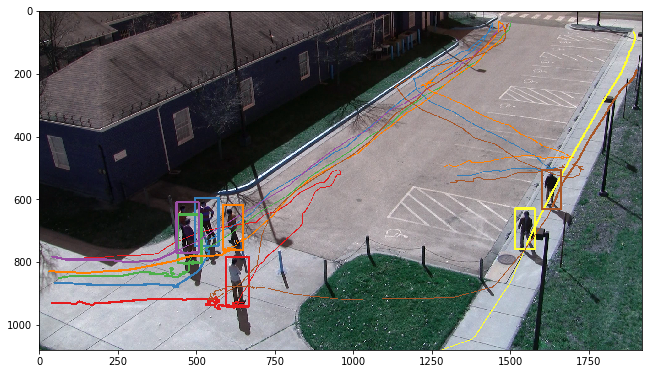

In [15]:
cap = cv2.VideoCapture(video_filename)

cap.set(1, frame_id)
ret, frame = cap.read()

img = frame.copy()
colors = [(228,26,28), (55,126,184), (77,175,74), (152,78,163), (255,127,0), (255,255,51), (166,86,40), (247,129,191)]
for i, row in enumerate(df[df.current_frame == frame_id].iterrows()):
    cv2.rectangle(
        img, 
        (row[1].left_top_x, row[1].left_top_y), 
        (row[1].left_top_x + row[1].width,row[1].left_top_y + row[1].height), 
        colors[i], 5)
    track = get_track(df, row[1].object_id, (None, row[1].current_frame))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 5)
    
    track = get_track(df, row[1].object_id, (row[1].current_frame, None))
    coords = get_track_coordinates(track)
    cv2.polylines(img, [coords], False, colors[i], 2)

plt.figure(figsize=(10.8, 19.2))
plt.imshow(img)
plt.show()


## Теперь нужно перевести треки в мировые координаты

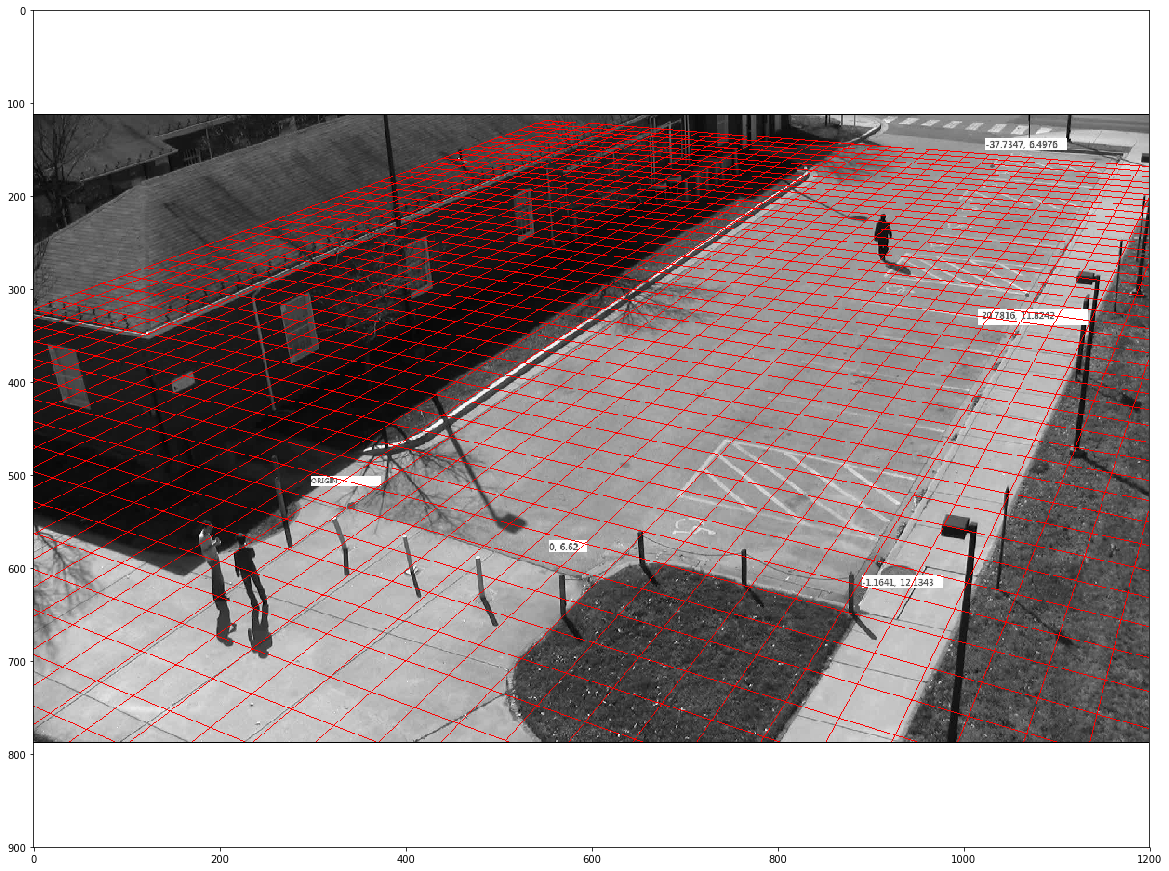

In [16]:
# отрисуем картинку, демонстрирующую нужное преобразование

plt.figure(figsize=(20, 40))
plt.imshow(cv2.imread(scene_homography_img))
plt.show()

In [17]:
# матрица гомографии нашей сцены
H = np.loadtxt(scene_homography_filename, dtype=np.float, delimiter=',')
H

array([[-2.5796104e-04,  9.3565491e-04, -4.9343613e-01],
       [ 5.7183404e-04,  8.2778391e-04, -8.6963374e-01],
       [ 1.5464549e-06,  4.0565615e-05,  1.6012838e-02]])

### Описание гомографии из документации

Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.

$$[xw,yw,zw] = H*[xi,yi,1]$$


$xi$: horizontal axis on image with left top corner as origin, increases right. 

$yi$: vertical axis on image with left top corner as origin, increases downward.

$xw/zw$: world x coordinate

$yw/zw$: world y coordiante



In [18]:
def transform(input_xy, H):
    coords = np.ones((input_xy.shape[0], 3))
    coords[:, :2] = input_xy
    word_frame_coords = H.dot(coords.T).T
    word_frame_coords[:, 0] /= word_frame_coords[:, 2]
    word_frame_coords[:, 1] /= word_frame_coords[:, 2]
    return word_frame_coords[:, :2]


###  Нарисуем преобразованные треки и референсные точки 

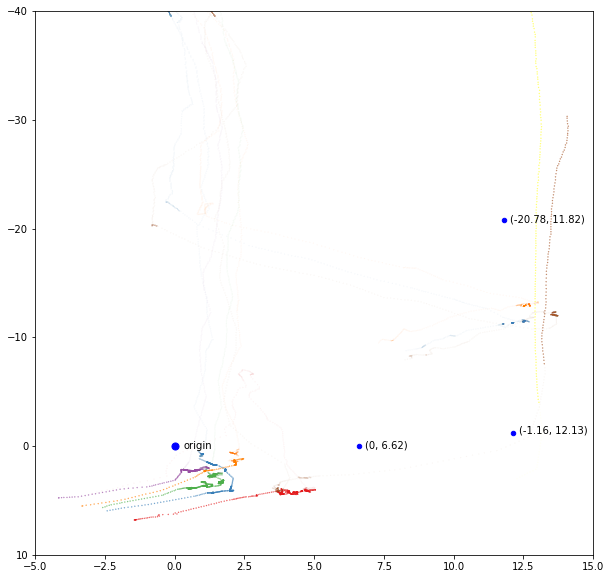

In [19]:
plt.figure(figsize=(10, 10))

for i, row in enumerate(df[df.current_frame == frame_id].iterrows()):
    track = get_track(df, row[1].object_id, (None, row[1].current_frame))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(word_frame_coords[:, 1], word_frame_coords[:, 0], c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255, s=0.1)
    
    track = get_track(df, row[1].object_id, (row[1].current_frame, None))
    coords = get_track_coordinates(track)
    word_frame_coords = transform(coords, H)
    plt.scatter(word_frame_coords[:, 1], word_frame_coords[:, 0], c=np.tile(colors[i], (word_frame_coords.shape[0], 1)).astype(np.float) / 255, s=0.01, alpha=0.2)

plt.xlim((-5, 15))
plt.ylim((10,-40))

plt.scatter(0, 0, c='b', s=50)
plt.annotate('origin', xy=(0, 0), xytext=(0.3, 0.3))

plt.scatter(6.62, 0, c='b', s=20)
plt.annotate('(0, 6.62)', xy=(0, 0), xytext=(6.82, 0.2))

plt.scatter(12.13, -1.16, c='b', s=20)
plt.annotate('(-1.16, 12.13)', xy=(0, 0),  xytext=(12.33, -1.16))

plt.scatter(11.82, -20.78, c='b', s=20)
plt.annotate('(-20.78, 11.82)', xy=(0, 0),  xytext=(12.02, -20.58))

plt.show()

In [20]:
def get_scene_id(name):
    return re.findall(r'[0-9][0-9][0-9][0-9]', name)[0]

In [21]:
scene_id_to_object_annotations = dict()
for filename in id_to_object_annotation_filename.values():
    scene_id = get_scene_id(filename)
    dataframe = pd.read_csv(filename, delim_whitespace=True, names=OBJECT_ANNOTATION_FIELDS)
    if scene_id in scene_id_to_object_annotations:
        scene_id_to_object_annotations[scene_id] = pd.concat([
            scene_id_to_object_annotations[scene_id], dataframe
        ])
    else:
        scene_id_to_object_annotations[scene_id] = dataframe
        
scene_id_to_homography = dict()
for filename in id_to_scene_homographies_filename.values():
    scene_id = get_scene_id(filename)
    scene_id_to_homography[scene_id] = np.loadtxt(filename, dtype=np.float, delimiter=',')


In [22]:
for key in sorted(scene_id_to_object_annotations.keys()):
    print("Scene %s containes %3d unique objects and %7d rows in dataset" % (
        key, len(scene_id_to_object_annotations[key].object_id.unique()), len(scene_id_to_object_annotations[key])))

Scene 0000 containes  30 unique objects and  617106 rows in dataset
Scene 0001 containes 328 unique objects and  603345 rows in dataset
Scene 0002 containes 110 unique objects and  757039 rows in dataset
Scene 0100 containes  63 unique objects and  453453 rows in dataset
Scene 0101 containes 297 unique objects and 2994852 rows in dataset
Scene 0102 containes  59 unique objects and  589965 rows in dataset
Scene 0400 containes 104 unique objects and  874692 rows in dataset
Scene 0401 containes  82 unique objects and  728793 rows in dataset
Scene 0500 containes 125 unique objects and  546557 rows in dataset
Scene 0502 containes  22 unique objects and  213225 rows in dataset
Scene 0503 containes 518 unique objects and 1443750 rows in dataset


In [23]:
VALIDATION_SCENE_ID = '0000'
TEST_SCENE_ID = '0001'
TRAIN_SCENE_IDS = ['0002', '0100', '0101', '0102', '0400', '0401', '0500', '0502', '0503']

In [112]:
def process_track(track, H, history_length, prediction_length, decimation_rate, track_mode):
    coordinates = transform(
        get_track_coordinates(track.sort_values('current_frame'), decimation_rate=decimation_rate), H)
    if track_mode == 'diff':
        coordinates = coordinates[1:, :] - coordinates[:-1, :]
    elif track_mode == 'relative':
        coordinates = (coordinates - coordinates[history_length - 1])
    elif track_mode == 'absolute':
        pass
    else:
        ValueError('Unknown mode %s' % track_mode)
    return coordinates[:history_length], coordinates[history_length:history_length+prediction_length]
        

def deterministic_data_generator(
        scene_id, 
        history_length=15, prediction_length=25, decimation_rate=5, 
        batch_size=16, generator_length=10, track_mode='relative'):
    df = scene_id_to_object_annotations[scene_id]
    H = scene_id_to_homography[scene_id]
    all_object_ids = df.object_id.unique()
    def internal_generator():
        batch_features = []
        batch_gt = []
        generated_batches = 0
        for object_id in all_object_ids:
            full_track = get_track(df, object_id, (None, None))
            for row_id in range(history_length + 1, len(full_track) - prediction_length, history_length + prediction_length):
                start_point = full_track.iloc[row_id]
                track = get_track(
                    df, object_id, 
                    (start_point.current_frame - (history_length + 1) * decimation_rate, 
                     start_point.current_frame + prediction_length * decimation_rate))
                if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                    continue
                X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
                batch_features.append(X)
                batch_gt.append(y)
                if len(batch_features) == batch_size:
                    yield np.concatenate([batch_features]), np.concatenate([batch_gt])
                    generated_batches += 1
                    if generated_batches == generator_length:
                        return 
                    batch_features = []
                    batch_gt = []
    while True:
        for X, y in internal_generator():
            yield X, y 

def random_data_generator(
        scene_ids, 
        history_length=15, prediction_length=25, 
        batch_size=16, decimation_rate=5, track_mode='relative'):
    while True:
        scene_id = np.random.choice(scene_ids)
        df = scene_id_to_object_annotations[scene_id]
        H = scene_id_to_homography[scene_id]
        all_object_ids = df.object_id.unique()
        batch_features = []
        batch_gt = []        
        while len(batch_features) < batch_size:
            object_id = np.random.choice(all_object_ids)
            full_track = get_track(df, object_id, (None, None))
            start_point = full_track.sample(1).iloc[0]
            track = get_track(
                df, object_id, 
                (start_point.current_frame - (history_length + 1) * decimation_rate, start_point.current_frame + prediction_length * decimation_rate))
            if len(track) != (prediction_length + history_length + 1) * decimation_rate:
                continue
            X, y = process_track(track, H, history_length, prediction_length, decimation_rate, track_mode)
            batch_features.append(X)
            batch_gt.append(y)
        yield np.concatenate([batch_features]), np.concatenate([batch_gt])


In [99]:
train_generator = random_data_generator(TRAIN_SCENE_IDS, batch_size=8, track_mode='relative')

In [101]:
%%time
X, y = next(train_generator)


CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 140 ms


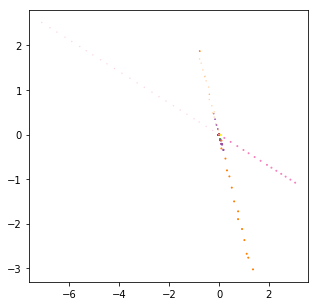

In [102]:

X1 = X + X[:, -1:, :]
y1 = y + X[:, -1:, :]
plt.figure(figsize=(5, 5))

for i in range(min(X.shape[0], len(colors))):
    plt.scatter(X1[i, :, 1], X1[i, :, 0], c=np.tile(colors[i], (X.shape[1], 1)).astype(np.float) / 255, s=1)
    plt.scatter(y1[i, :, 1], y1[i, :, 0], c=np.tile(colors[i], (y.shape[1], 1)).astype(np.float) / 255, s=0.1, alpha=0.5)


#  Метрики и модели

## Какие модели мы будем обсуждать и где почитать подробнее?
* #### Peeking into the Future: Predicting Future Person Activities and Locations in Videos (CVPR 2019)
    - https://arxiv.org/abs/1902.03748 - ссылка на статью
    - https://github.com/google/next-prediction - ссылка на код
  
* #### Social LSTM: Human Trajectory Prediction in Crowded Spaces (CVPR 2016)
    - http://openaccess.thecvf.com/content_cvpr_2016/papers/Alahi_Social_LSTM_Human_CVPR_2016_paper.pdf - ссылка на статью
* #### Social GAN: Socially Acceptable Trajectories with Generative Adversarial Networks
    - https://arxiv.org/abs/1803.10892 - ссылка на статью
    - https://github.com/agrimgupta92/sgan - ссылка на код

## Какие метрики принято публиковать?
* Average displacement error - the mean square error (MSE) over all estimated points of a trajectory and the true points.
* $MinADE_k$ - the minimum average displacement error over k most likely trajectories.
* Final displacement error - the distance between the predicted final destination and the true final destination at end of the prediction period $T_{pred}$.
* $MinFDE_k$ - the minimum final displacement error over k most likely trajectories.
* Average non-linear displacement error - The is the MSE at the non-linear regions of a trajectory. 


### Шаблон для обучения модели

In [84]:
import tensorflow as tf
from tensorflow import keras

In [259]:
history_length = 15 
prediction_length = 25 
hidden_size = 64 
batch_size = 16
decimation_rate = 5
validation_steps = 50
mode = 'diff'

In [260]:
input_layer = keras.layers.Input(shape=(history_length, 2))
# your model here
output_layer = keras.layers.TimeDistributed(keras.layers.Dense(2), name='decoder_result')(layer)


In [261]:
model = keras.Model(inputs=[input_layer], outputs=[output_layer])

In [1]:
model.summary()

In [255]:
! mkdir -p models

In [263]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [264]:
train_generator = random_data_generator(TRAIN_SCENE_IDS, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=mode)
val_generator = deterministic_data_generator(VALIDATION_SCENE_ID, generator_length=validation_steps, batch_size=batch_size, history_length=history_length, prediction_length=prediction_length, track_mode=mode)


In [2]:
model.fit_generator(
    train_generator, steps_per_epoch=200, 
    validation_data=val_generator, validation_steps=validation_steps, 
    callbacks=[keras.callbacks.ModelCheckpoint('models/best_model.h5', save_best_only=True)],
    epochs=20)

In [126]:
model.load_weights('models/best_model.h5')

In [266]:
generator = random_data_generator(
    [VALIDATION_SCENE_ID], batch_size=1, 
    history_length=history_length, prediction_length=prediction_length, track_mode=mode)


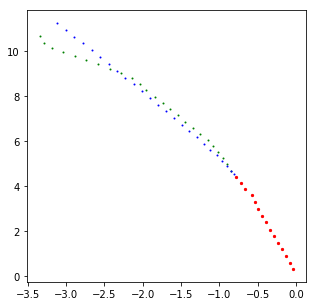

In [269]:
X, y = next(generator)
y_pred = model.predict(X)

plt.figure(figsize=(5, 5))

idx = 0
if mode == 'diff':
    coordinates = np.cumsum(np.concatenate([X[idx], y[idx]], axis=0), axis=0)
    x_plot = coordinates[:history_length]
    y_plot = coordinates[history_length:]
    coordinates_prediction = np.cumsum(np.concatenate([X[idx], y_pred[idx]], axis=0), axis=0)
    y_pred_plot = coordinates_prediction[history_length:]
elif mode == 'relative':
    x_plot = X[idx] + X[idx, -1, :]
    y_plot = y[idx] + X[idx, -1, :]
    y_pred_plot = y_pred[idx] + X[idx, -1, :]
elif mode == 'absolute':
    x_plot = X[idx]
    y_plot = y[idx]
    y_pred_plot = y_pred[idx]

plt.scatter(x_plot[:, 1], x_plot[:, 0], c='r', s=5)
plt.scatter(y_plot[:, 1], y_plot[:, 0], c='g', s=1)
plt.scatter(y_pred_plot[:, 1], y_pred_plot[:, 0], c='b', s=1)

plt.show()

## Задание
1. Реализуйте линейную модель предсказания траектории пешеходов (1 балл)
    * модель учитывает всю историю и это улучшает метрики в сравнении с короткой историей 2-3 таймстемпа из прошлого (+1 балл)
2. Посчитайте метрики: ADE и FDE по сценам (1 балл)
3. Реализуйте рекуррентную модель предсказания траектории и обучите до сходимости (1 балл)
    * нарисуйте 5-10 примеров визуально хорошего предсказания (+1 балл)
    * модель обыгрывает линейное предсказание на тесте (+1 балл)
4. Используйте любой дополнительный фактор, доступный в датасете (1 балл)
    * модель обыгрывает предыдущий пункт на тесте (+1 балл)
5. Сделайте сглаживание сырых траекторий (до прореживания) фильтром Калмана (1 балл), посмотрите, как изменились абсолюты метрик (1 балл)
6. Произвольное улучшение базовой архитектуры (нет, увеличить глубину - это не улучшение), сделать замеры (до +2 баллов)


NB: за баги в реализации моделей снимаются баллы за победу в сравнениях

По итогам этого задания ожидается читаемый отчёт с текстовыми комментариями, метриками на тесте и валидации, примерами предсказания. Результаты, не вошедшие в отчёт в финальной оценке засчитаны не будут 